# RealNVP

## Initialize

### Init

In [1]:
import os
import sys
import numpy as np
import tensorflow as tf
import tensorflow_probability as tfp
import numpy as np
tfd = tfp.distributions
tfb = tfp.bijectors
import pandas as pd
import pickle
from timeit import default_timer as timer
import traceback
from typing import Dict, Any
import scipy
from scipy.stats import norm, multivariate_normal

sys.path.append('code')
import Bijectors,Distributions,Metrics,MixtureDistributions,Plotters,Trainer,Utils

os.environ["CUDA_VISIBLE_DEVICES"] = "1"
gpu_devices = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(gpu_devices[0], True)

In [24]:
import six
import numpy as np

input_size = 5
input_order = 'left-to-right'

def _create_input_order(input_size, input_order='left-to-right', seed=None):
  """Returns a degree vectors for the input."""
  if isinstance(input_order, six.string_types):
    if input_order == 'left-to-right':
      return np.arange(start=1, stop=input_size + 1)
    elif input_order == 'right-to-left':
      return np.arange(start=input_size, stop=0, step=-1)
    elif input_order == 'random':
      ret = np.arange(start=1, stop=input_size + 1)
      if seed is None:
        rng = np.random
      else:
        rng = np.random.RandomState(seed)
      rng.shuffle(ret)
      return ret
  elif np.all(np.sort(np.array(input_order)) == np.arange(1, input_size + 1)):
    return np.array(input_order)

hidden_units = [8,10]
hidden_degrees = 'equal'
input_order = _create_input_order(input_size, input_order)
degrees = [input_order]


for units in hidden_units:
    if isinstance(hidden_degrees, six.string_types):
      if hidden_degrees == 'random':
        if seed is None:
          rng = np.random
        else:
          rng = np.random.RandomState(seed)
        # samples from: [low, high)
        degrees.append(
            rng.randint(low=min(np.min(degrees[-1]), input_size - 1),
                        high=input_size,
                        size=units))
      elif hidden_degrees == 'equal':
        min_degree = min(np.min(degrees[-1]), input_size - 1)
        degrees.append(np.maximum(
            min_degree,
            # Evenly divide the range `[1, input_size - 1]` in to `units + 1`
            # segments, and pick the boundaries between the segments as degrees.
            np.ceil(np.arange(1, units + 1)
                    * (input_size - 1) / float(units + 1)).astype(np.int32)))

degrees

[array([1, 2, 3, 4, 5]),
 array([1, 1, 2, 2, 3, 3, 4, 4]),
 array([1, 1, 2, 2, 2, 3, 3, 3, 4, 4])]

### Sample distribution

In [7]:
def MixNormal1(n_components=3,n_dimensions=4,seed=0):
    np.random.seed(seed)
    loc = np.random.sample([n_components,n_dimensions])*10
    scale = np.random.sample([n_components,n_dimensions])
    probs = np.random.sample([n_dimensions,n_components])
    components = []
    for i in range(n_components):
        components.append(tfd.Normal(loc=loc[i],scale=scale[i]))
    mix_gauss=tfd.Mixture(
        cat=tfd.Categorical(probs=probs),
        components=components,
        validate_args=True)
    return mix_gauss

In [1]:
import pickle
try:
    file.close()
except:
    pass
file = open(r"C:\Users\Riccardo Torre\Dropbox\Work\04_Projects\Git\GitHub\NormalizingFlows\NormalizingFlowsHD-2\Riccardo\UMoG\results\MAFN_uncorr\run_1\samples.pkl", 'rb')
target_samples = pickle.load(file)
nf_samples = pickle.load(file)

In [9]:
import corner
import matplotlib.lines as mlines
def cornerplotter(target_test_data,nf_dist,path_to_plots,ndims,rot=None,norm=False,max_dim=32):
    # Define the two samples (target and nf)
    shape = target_test_data.shape
    target_samples=target_test_data
    if norm==False:
        nf_samples=nf_dist.sample(shape[0]).numpy()
        if rot is not None:
            nf_samples = np.dot(nf_samples,np.transpose(rot))
    else:
        nf_samples=nf_dist
    # Define generic labels
    labels = []
    for i in range(shape[1]):
        labels.append(r"$\theta_{%d}$" % i)
        i = i+1
    # Choose dimensions to plot
    thin = int(shape[1]/max_dim)+1
    if thin<=2:
        thin = 1
    # Select samples to plot
    target_samples = target_samples[:,::thin]
    nf_samples = nf_samples[:,::thin]
    # Select labels
    labels = list(np.array(labels)[::thin])

    n_bins = 50
    #red_bins=50
    #density=(np.max(target_samples,axis=0)-np.min(target_samples,axis=0))/red_bins
    #
    #blue_bins=(np.max(nf_samples,axis=0)-np.min(nf_samples,axis=0))/density
    #blue_bins=blue_bins.astype(int).tolist()

    blue_line = mlines.Line2D([], [], color='red', label='target')
    red_line = mlines.Line2D([], [], color='blue', label='NF')
    figure=corner.corner(target_samples,color='red',bins=n_bins,labels=[r"%s" % s for s in labels])
    corner.corner(nf_samples,color='blue',bins=n_bins,fig=figure)
    plt.legend(handles=[blue_line,red_line], bbox_to_anchor=(-ndims+1.8, ndims+.3, 1., 0.) ,fontsize='xx-large')
    plt.savefig(path_to_plots+'/corner_plot.pdf',pil_kwargs={'quality':50})
    plt.close()
    return

In [21]:
nf_samples
np.count_nonzero([np.all(x) for x in np.isnan(nf_samples)])
nf_samples[~np.isnan(nf_samples).any(axis=1), :]

array([[ 7.116843  , 14.888423  , -7.625441  , ...,  7.897599  ,
        -1.1656535 , -9.104275  ],
       [ 8.107322  ,  4.4148088 , -1.2412763 , ...,  7.4618697 ,
        -1.0998064 , -8.436045  ],
       [ 5.447466  ,  6.0848513 , -1.1414104 , ...,  7.1878257 ,
        -2.8834138 , -6.1389403 ],
       ...,
       [ 5.335146  ,  9.072717  , -0.70228434, ...,  7.408063  ,
        -2.2535658 , -7.7458124 ],
       [ 9.854728  ,  4.3577056 , -7.750685  , ...,  6.43229   ,
        -1.5007486 , -8.559337  ],
       [ 9.592716  , -2.0059025 , -1.2982723 , ...,  6.8674784 ,
        -0.86702096, -7.2643313 ]], dtype=float32)

ValueError: supplied range of [nan, nan] is not finite

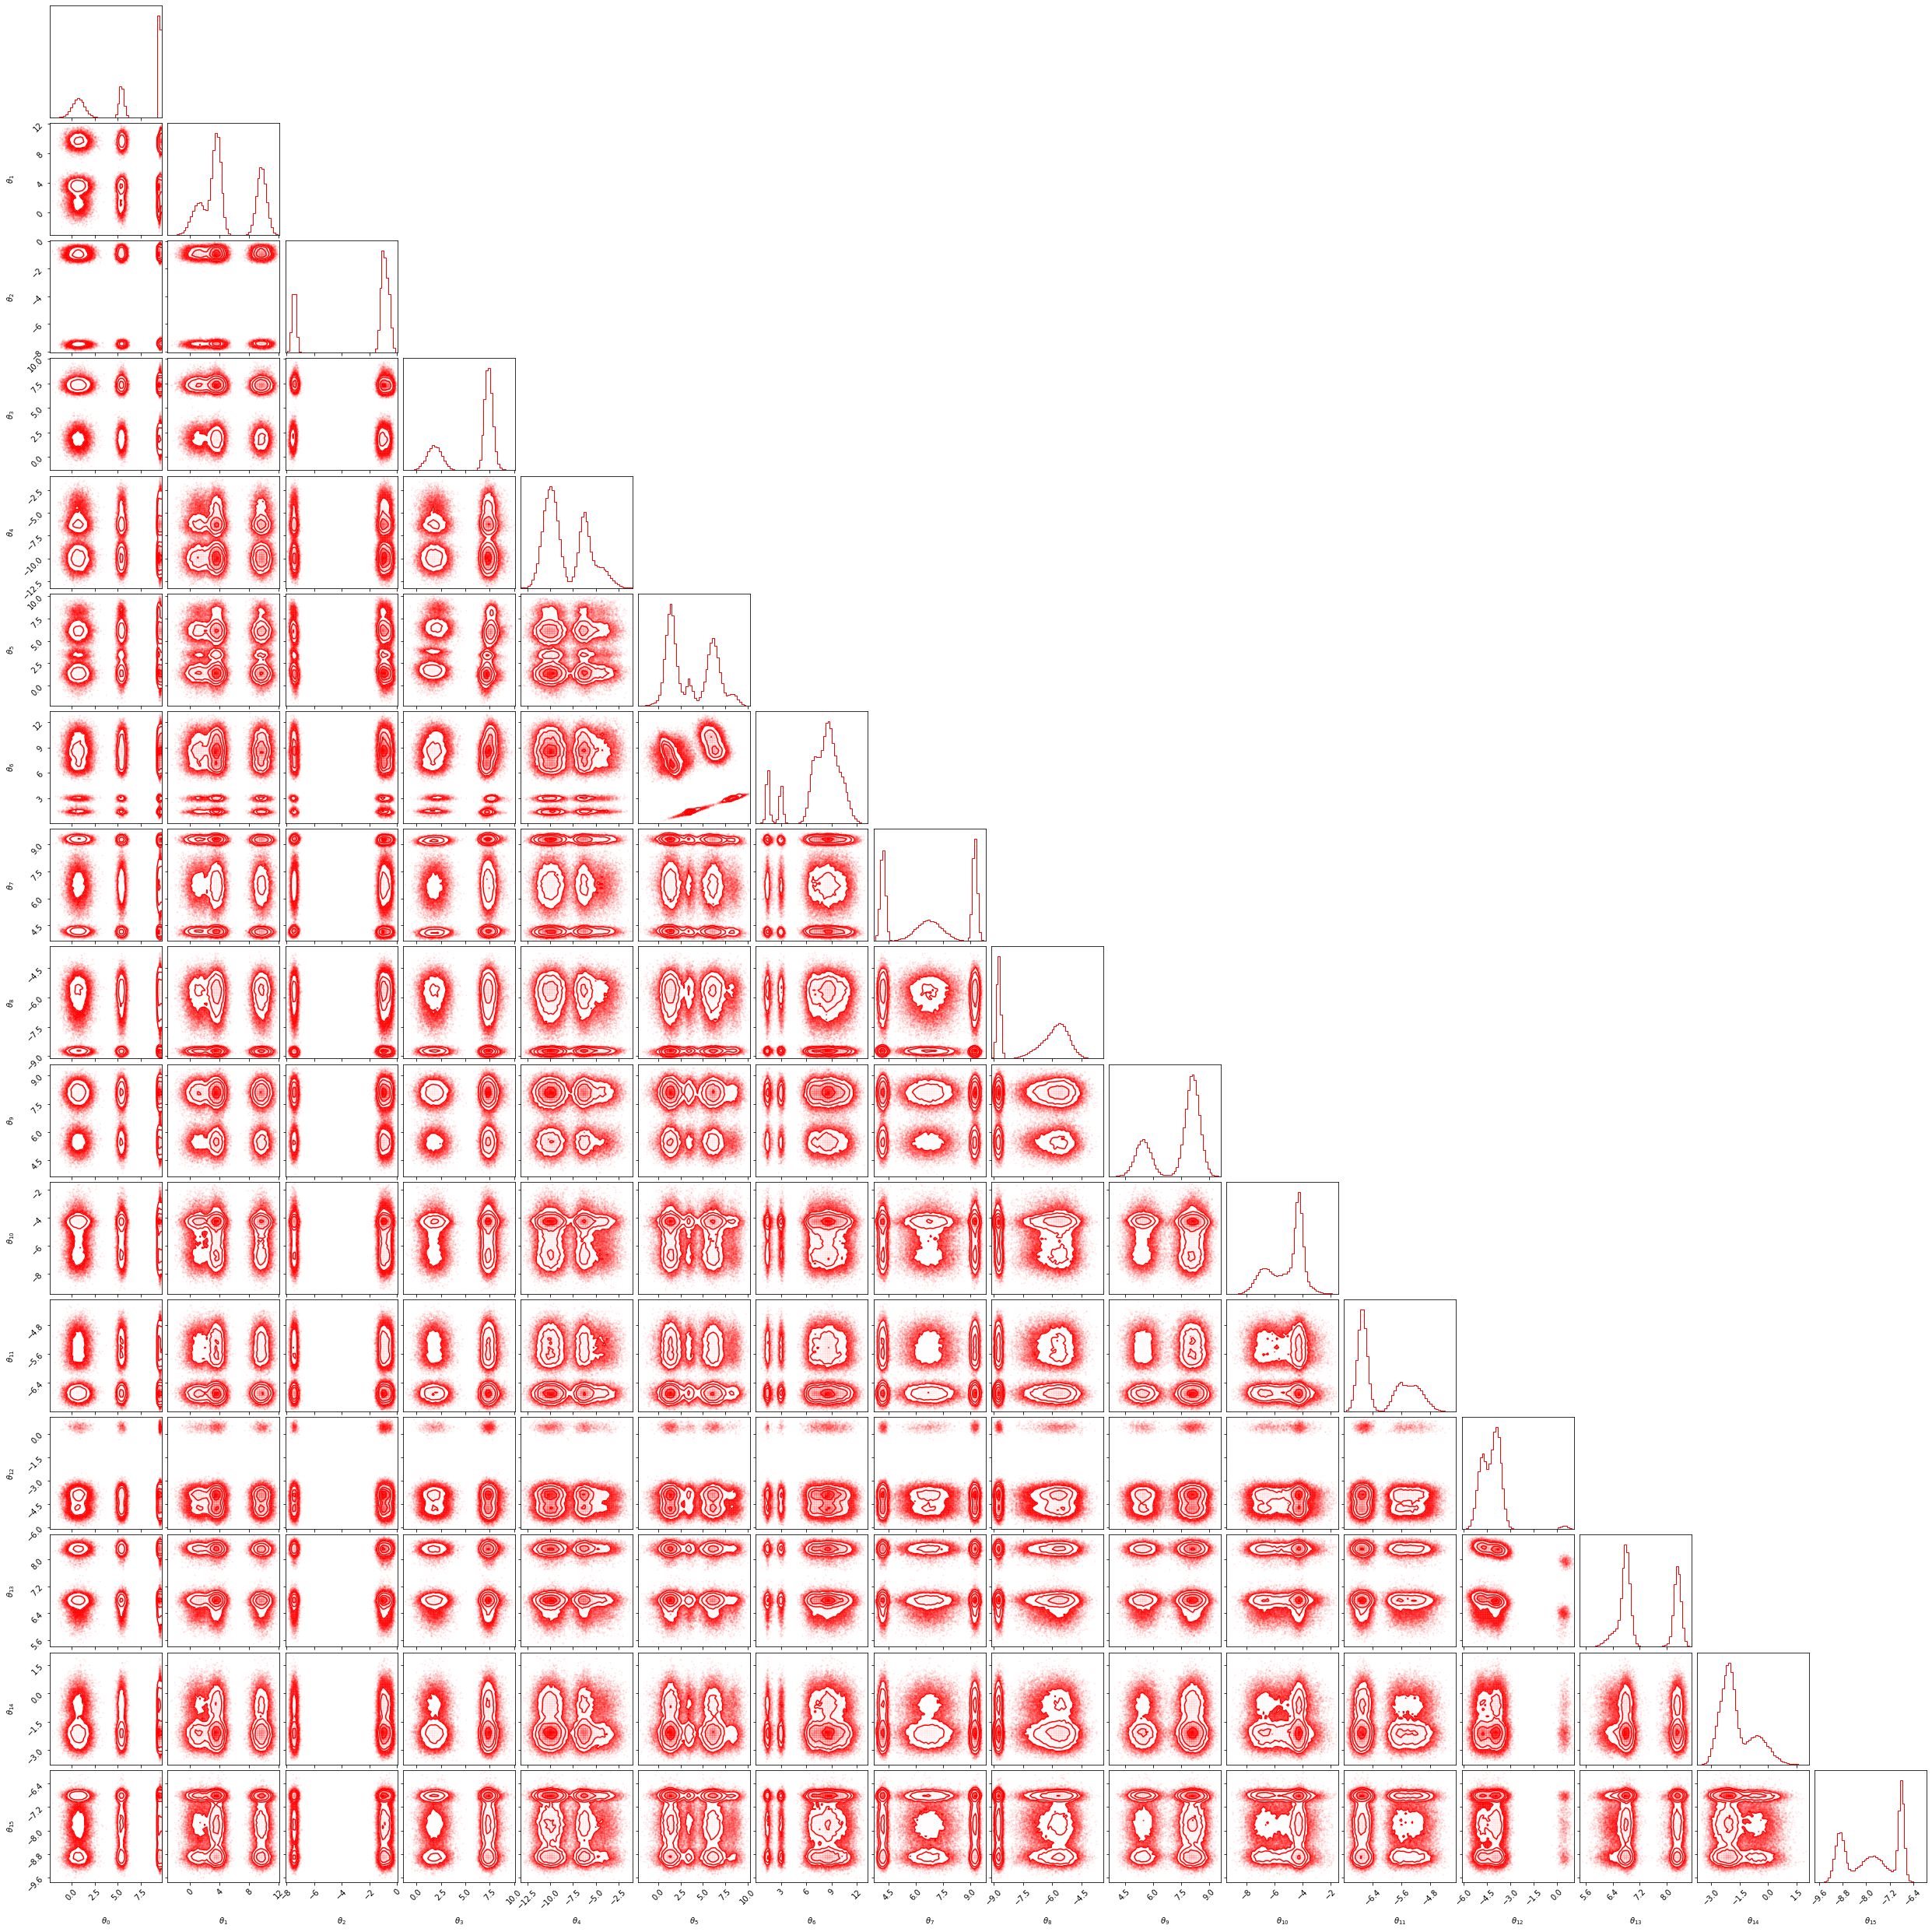

In [10]:
cornerplotter(target_samples,
              nf_samples,
              r"C:\Users\Riccardo Torre\Dropbox\Work\04_Projects\Git\GitHub\NormalizingFlows\NormalizingFlowsHD-2\Riccardo\UMoG\results\MAFN_uncorr\run_1",
              10,
              rot=None,
              norm=True,
              max_dim=32)

## Set parameters

In [8]:
### Initialize number of components ###
ncomp = 3

### Initialize hyperparameters lists ###
ndims_list = [10]
corr_uncorr_list = ["corr"]
regulariser_list = [None]
eps_regularisers = [0]
nsamples_list = [100000]
batch_size_list = [512]
bijectors_list = ['RealNVPN']
activation_list = ['relu']
nbijectors_list = [2]
hidden_layers_list = [[128,128,128]]
seeds_list = [0]
n_displays = 1

### Initialize variables for the neural splines ###
range_min_list = [-5]
spline_knots_list = [8]

### Initialize train hyerparameters ###
ntest_samples = 100000
epochs = 500
lr_orig = .001
patience = 50
min_delta_patience=.0001
lr_change=.2
seed_dist = 0
seed_test = 0

In [9]:
### Initialize output dir ###
mother_output_dir='Main_notebook_output/'
try:
    os.mkdir(mother_output_dir)
except:
    print('file exists')

### Initialize dictionaries ###
results_dict: Dict[str,Any] = {'run_n': [],'run_seed': [], 'ndims':[],'nsamples':[],'correlation':[],'nbijectors':[],'bijector':[],'activation':[],'spline_knots':[],'range_min':[],'eps_regulariser':[],'regulariser':[],'kl_divergence':[],'ks_test_mean':[],'ks_test_median':[],'ad_test_mean':[],'ad_test_median':[],'Wasserstein_median':[],'Wasserstein_mean':[],'frob_norm':[],'hidden_layers':[],'batch_size':[],'epochs_input':[],'epochs_output':[],'time':[]}
hyperparams_dict: Dict[str,Any] = {'run_n': [],'run_seed': [], 'ndims':[],'nsamples':[],'correlation':[],'nbijectors':[],'bijector':[],'spline_knots':[],'range_min':[],'hidden_layers':[],'batch_size':[],'activation':[],'eps_regulariser':[],'regulariser':[],'dist_seed':[],'test_seed':[]}

### Create 'log' file ####
log_file_name = Utils.create_log_file(mother_output_dir,results_dict)

### Run loop  ###
run_number = 0
n_runs = len(ndims_list)*len(seeds_list)*len(nsamples_list)*len(corr_uncorr_list)*len(activation_list)*len(eps_regularisers)*len(regulariser_list)*len(bijectors_list)*len(nbijectors_list)*len(spline_knots_list)*len(range_min_list)*len(batch_size_list)*len(hidden_layers_list)
for ndims in ndims_list:
    print("===========\nGenerating test data for ndims=",ndims,".\n")
    print("===========\n")
    start=timer()
    targ_dist=MixtureGaussian(ncomp,ndims,seed=seed_dist)
    X_data_test=targ_dist.sample(ntest_samples,seed=seed_test).numpy()
    end=timer()
    test_data_time=end-start
    print("Test data generated in",test_data_time,"s.\n")
    for seed in seeds_list:
        for nsamples in nsamples_list:
            for activation in activation_list:
                for eps_regulariser in eps_regularisers:
                    for regulariser in regulariser_list:
                        for bijector_name in bijectors_list:
                            for nbijectors in nbijectors_list:
                                for spline_knots in spline_knots_list:
                                    for range_min in range_min_list:
                                        for batch_size in batch_size_list:
                                            for hidden_layers in hidden_layers_list:
                                                for corr in corr_uncorr_list:
                                                    Utils.reset_random_seeds(seed)
                                                    run_number = run_number + 1
                                                    results_dict_saved=False
                                                    logger_saved=False
                                                    results_current_saved=False
                                                    details_saved=False
                                                    path_to_results=mother_output_dir+'run_'+str(run_number)+'/'
                                                    to_run=True
                                                    try:    
                                                        os.mkdir(path_to_results)
                                                    except:
                                                        print(path_to_results+' file exists')
                                                        to_run=False
                                                    try:
                                                        if to_run:
                                                            path_to_weights=path_to_results+'weights/'
                                                            try:
                                                                os.mkdir(path_to_weights)
                                                            except:
                                                                print(path_to_weights+' file exists')
                                                            print("===========\nGenerating train data for run",run_number,".\n")
                                                            print("===========\n")
                                                            start=timer()
                                                            X_data_train=targ_dist.sample(nsamples,seed=seed).numpy()
                                                            if corr == "corr":
                                                                V = None
                                                            elif corr == "uncorr":
                                                                V = MixtureDistributions.rot_matrix(X_data_train)
                                                                X_data_train = MixtureDistributions.transform_data(X_data_train,V)
                                                                X_data_test = MixtureDistributions.transform_data(X_data_test,V)
                                                            else:
                                                                V = None
                                                            end=timer()
                                                            train_data_time=end-start
                                                            print("Train data generated in",train_data_time,"s.\n")       
                                                            hllabel='-'.join(str(e) for e in hidden_layers)
                                                            Utils.save_hyperparams(path_to_results,hyperparams_dict,run_number,seed,ndims,nsamples,corr,bijector_name,nbijectors,spline_knots,range_min,hllabel,batch_size,activation,eps_regulariser,regulariser,seed_dist,seed_test)
                                                            print("===========\nRunning",run_number,"/",n_runs,"with hyperparameters:\n",
                                                                  "ndims=",ndims,"\n",
                                                                  "seed=",seed,"\n",
                                                                  "nsamples=",nsamples,"\n",
                                                                  "correlation=",corr,"\n",
                                                                  "activation=",activation,"\n",
                                                                  "eps_regulariser=",eps_regulariser,"\n",
                                                                  "regulariser=",regulariser,"\n",
                                                                  "bijector=",bijector_name,"\n",
                                                                  "nbijectors=",nbijectors,"\n",
                                                                  "spline_knots=",spline_knots,"\n",
                                                                  "range_min=",range_min,"\n",
                                                                  "batch_size=",batch_size,"\n",
                                                                  "hidden_layers=",hidden_layers,
                                                                  "epocs_input=",epochs,
                                                                  "\n===========\n")
                                                            bijector=Bijectors.ChooseBijector(bijector_name,ndims,spline_knots,nbijectors,range_min,hidden_layers,activation,regulariser,eps_regulariser)
                                                            Utils.save_bijector_info(bijector,path_to_results)
                                                            base_dist=Distributions.gaussians(ndims)
                                                            nf_dist=tfd.TransformedDistribution(base_dist,bijector)
                                                            #start=timer()
                                                            #print("Training model.\n")
                                                            #epochs_input = epochs
                                                            #lr=lr_orig
                                                            #n_displays=1
                                                            #print("Train first sample:",X_data_train[0])
                                                            #history=Trainer.graph_execution(ndims,nf_dist, X_data_train,epochs, batch_size, n_displays,path_to_results,load_weights=True,load_weights_path=path_to_weights,lr=lr,patience=patience,min_delta_patience=min_delta_patience,reduce_lr_factor=lr_change,seed=seed)
                                                            #t_losses_all=list(history.history['loss'])
                                                            #v_losses_all=list(history.history['val_loss'])
                                                            #end=timer()
                                                            #epochs_output = len(t_losses_all)
                                                            #training_time=end-start
                                                            #print("Model trained in",training_time,"s.\n")
                                                            ##continue
                                                            #start=timer()
                                                            #print("===========\nComputing predictions\n===========\n")
                                                            #with tf.device('/device:CPU:0'):
                                                            #    if V is not None:
                                                            #        X_data_train = MixtureDistributions.inverse_transform_data(X_data_train,V)
                                                            #        X_data_test = MixtureDistributions.inverse_transform_data(X_data_test,V)
                                                            #    #reload_best
                                                            #    nf_dist,_=Utils.load_model(nf_dist,path_to_results,ndims,lr=.000001)
                                                            #    logprob_nf=nf_dist.log_prob(X_data_test).numpy()
                                                            #    pickle_logprob_nf=open(path_to_results+'logprob_nf.pcl', 'wb')
                                                            #    pickle.dump(logprob_nf, pickle_logprob_nf, protocol=4)
                                                            #    pickle_logprob_nf.close()
                                                            #    X_data_nf=Utils.nf_sample_save(nf_dist,path_to_results,sample_size=ntest_samples,rot=V,iter_size=10000,seed=seed)
                                                            #    print("Test first sample:",X_data_test[0])
                                                            #    print("NF first sample:",X_data_nf[0])
                                                            #    kl_divergence,ks_median,ks_mean,ad_mean,ad_median,w_distance_median,w_distance_mean,frob_norm,nf_corr,target_corr=Metrics.ComputeMetrics(X_data_test,X_data_nf)
                                                            #    results_dict=Utils.ResultsToDict(results_dict,run_number,seed,ndims,nsamples,corr,bijector_name,nbijectors,activation,spline_knots,range_min,kl_divergence,ks_mean,ks_median,ad_mean,ad_median,w_distance_median,w_distance_mean,frob_norm,hllabel,batch_size,eps_regulariser,regulariser,epochs_input,epochs_output,training_time)
                                                            #    results_dict_saved=True
                                                            #    print("Results dict saved")
                                                            #    Utils.logger(log_file_name,results_dict)
                                                            #    logger_saved=True
                                                            #    print("Logger saved")
                                                            #    Utils.results_current(path_to_results,results_dict)
                                                            #    results_current_saved=True
                                                            #    print("Results saved")
                                                            #    Utils.save_details_json(hyperparams_dict,results_dict,t_losses_all,v_losses_all,path_to_results)
                                                            #    details_saved=True
                                                            #    print("Details saved")
                                                            #    Plotters.train_plotter(t_losses_all,v_losses_all,path_to_results)
                                                            #    corner_start=timer()
                                                            #    Plotters.cornerplotter(X_data_test,X_data_nf,path_to_results,ndims,norm=True)
                                                            #    Plotters.marginal_plot(X_data_test,X_data_nf,path_to_results,ndims)
                                                            #    #Plotters.sample_plotter(X_data_test,nf_dist,path_to_results)
                                                            #    end=timer()
                                                            #    predictions_time=end-start
                                                            #    print("Model predictions computed in",predictions_time,"s.\n")
                                                        else:
                                                            print("===========\nRun",run_number,"/",n_runs,"already exists. Skipping it.\n")
                                                            print("===========\n")
                                                    except Exception as ex:
                                                        # Get current system exception
                                                        ex_type, ex_value, ex_traceback = sys.exc_info()
                                                        # Extract unformatter stack traces as tuples
                                                        trace_back = traceback.extract_tb(ex_traceback)
                                                        # Format stacktrace
                                                        stack_trace = list()
                                                        for trace in trace_back:
                                                            stack_trace.append("File : %s , Line : %d, Func.Name : %s, Message : %s" % (trace[0], trace[1], trace[2], trace[3]))
                                                        if not results_dict_saved:
                                                            results_dict=Utils.ResultsToDict(results_dict,run_number,seed,ndims,nsamples,corr,bijector_name,nbijectors,activation,spline_knots,range_min,"nan","nan","nan","nan","nan","nan","nan","nan",hllabel,batch_size,eps_regulariser,regulariser,epochs_input,"nan","nan")
                                                        if not logger_saved:
                                                            Utils.logger(log_file_name,results_dict)
                                                        if not results_current_saved:
                                                            Utils.results_current(path_to_results,results_dict)
                                                        if not details_saved:
                                                            try:
                                                                Utils.save_details_json(hyperparams_dict,results_dict,t_losses_all,v_losses_all,path_to_results)
                                                            except:
                                                                Utils.save_details_json(hyperparams_dict,results_dict,None,None,path_to_results)
                                                        print("===========\nRun failed\n")
                                                        print("Exception type : %s " % ex_type.__name__)
                                                        print("Exception message : %s" %ex_value)
                                                        print("Stack trace : %s" %stack_trace)
                                                        print("===========\n")   
results_frame=pd.DataFrame(results_dict)
results_frame.to_csv(mother_output_dir+'results_last_run.txt',index=False)
print("Everything done.")

file exists
Generating test data for ndims= 10 .


Test data generated in 1.3589132999999265 s.

Generating train data for run 1 .


Train data generated in 0.10322089999999662 s.

Running 1 / 1 with hyperparameters:
 ndims= 10 
 seed= 0 
 nsamples= 100000 
 correlation= corr 
 activation= relu 
 eps_regulariser= 0 
 regulariser= None 
 bijector= RealNVPN 
 nbijectors= 2 
 spline_knots= 8 
 range_min= -5 
 batch_size= 512 
 hidden_layers= [128, 128, 128] epocs_input= 500 

Everything done.


In [27]:
bijector.__dict__

{'_self_setattr_tracking': True,
 '_self_unconditional_checkpoint_dependencies': [TrackableReference(name=_bijectors_trackable, ref=ListWrapper([<tfp.bijectors.RealNVP 'real_nvp' batch_shape=? forward_min_event_ndims=True inverse_min_event_ndims=True dtype_x=? dtype_y=?>, <tfp.bijectors.Permute 'permute' batch_shape=[] forward_min_event_ndims=1 inverse_min_event_ndims=1 dtype_x=? dtype_y=?>, <tfp.bijectors.RealNVP 'real_nvp' batch_shape=? forward_min_event_ndims=True inverse_min_event_ndims=True dtype_x=? dtype_y=?>]))],
 '_self_unconditional_dependency_names': {'_bijectors_trackable': ListWrapper([<tfp.bijectors.RealNVP 'real_nvp' batch_shape=? forward_min_event_ndims=True inverse_min_event_ndims=True dtype_x=? dtype_y=?>, <tfp.bijectors.Permute 'permute' batch_shape=[] forward_min_event_ndims=1 inverse_min_event_ndims=1 dtype_x=? dtype_y=?>, <tfp.bijectors.RealNVP 'real_nvp' batch_shape=? forward_min_event_ndims=True inverse_min_event_ndims=True dtype_x=? dtype_y=?>])},
 '_self_uncon

In [22]:
isinstance(bijector,tfb.Bijector)

True

In [20]:
isinstance(bijector,tfb._Chain)

AttributeError: module 'tensorflow_probability.python.bijectors' has no attribute '_Chain'

In [23]:
distribution = tfd.TransformedDistribution(base_dist,bijector)

In [26]:
distribution.__dict__

{'_parameters': {'distribution': <tfp.distributions.Sample 'SampleNormal' batch_shape=[] event_shape=[10] dtype=float32>,
  'bijector': <tfp.bijectors._Chain 'chain_of_real_nvp' batch_shape=[] forward_min_event_ndims=1 inverse_min_event_ndims=1 dtype_x=? dtype_y=? bijectors=[<tfp.bijectors.RealNVP 'real_nvp' batch_shape=? forward_min_event_ndims=True inverse_min_event_ndims=True dtype_x=? dtype_y=?>, <tfp.bijectors.Permute 'permute' batch_shape=[] forward_min_event_ndims=1 inverse_min_event_ndims=1 dtype_x=? dtype_y=?>, <tfp.bijectors.RealNVP 'real_nvp' batch_shape=? forward_min_event_ndims=True inverse_min_event_ndims=True dtype_x=? dtype_y=?>]>,
  'kwargs_split_fn': <function tensorflow_probability.python.distributions.transformed_distribution._default_kwargs_split_fn(kwargs)>,
  'validate_args': False,
  'parameters': None,
  'name': None},
 '_self_setattr_tracking': True,
 '_self_unconditional_checkpoint_dependencies': [TrackableReference(name=_distribution, ref=tfp.distributions.S

In [25]:
isinstance(distribution, tfp.distributions.Distribution)

True